# Gene Expression and Enzyme Kinetics 

## Gene Expression ODEs

![diagram](images/diagram.png)

Since all of the genes of interest are constitutively expressed, we can model their rates by the following ODES:

1. $$\frac{d[\text{ilvK}]}{dt} = \gamma_1 - \varsigma_1 \cdot [\text{ilvK}]$$

2. $$\frac{d[\text{bCAP}]}{dt} = \gamma_2 - \varsigma_2 \cdot [\text{bCAP}]$$

3. $$\frac{d[\text{BCKDH}]}{dt} = \gamma_3 - \varsigma_3 \cdot [\text{BCKDH}]$$

$\gamma$ represents the respective basal translation rates, and $\varsigma$ represents the respective breakdown factors.

## Enzyme Kinetics ODEs

![pathways](images/pathways.png)

The breakdown of all three branched chain amino acids follow a similar pathway:

1. $$\text{Reaction 1}: \text{BCAA} + \text{oxoglutarate} + \text{ilvK} \rightleftharpoons complex_1 \rightarrow \text{BCKA} + \text{ilvK} + \text{glutamate}$$

2. $$\text{Reaction 2}: \text{BCKA} + \text{BCKDH} + NAD^{+} + \text{CoA} \rightleftharpoons complex_2 \rightarrow \text{butanol-CoA} + \text{BCKDH} + \text{CO}_2 + \text{NADH}$$

We do not concern ourselves with the breakdown of butanol-COA.

Noting that the concentration of ilvK and BCKDH not only depend on enzyme kinetics but also gene expression, The ODEs then are as follows:

0. $$\frac{dBCAA_{out}}{dt} = -k_{in}[bCAP]$$

1. $$\frac{d[BCAA_{in}]}{dt} = -k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1]+ k_{in}[BCAP]$$

2. $$\frac{d[\text{bCAP}]}{dt} = \gamma_2 - \varsigma_2 [\text{bCAP}]$$

3. $$\frac{d[ilvK]}{dt} = (-k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1] + k_2[complex_1]) + (\gamma_1 - \varsigma_1 [\text{ilvK}])$$

4. $$\frac{d[complex_1]}{dt} = k_1[BCAA][ilvK] - k_{-1}[complex_1] - k_2[complex_1]$$

5. $$\frac{d[BCKA]}{dt} = k_2[complex_1] - k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2]$$

6. $$\frac{d[complex_2]}{dt} = k_3[BCKA][BCKDH][NAD+][CoA] - k_{-3}[complex_2] - k_{4}[complex_2]$$

7. $$\frac{d[BCKDH]}{dt} = (-k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2] + k_4[complex_2]) + (\gamma_3 - \varsigma_3 [\text{BCKDH}])$$

8. $$\frac{d[oxoglutarate]}{dt} = \frac{d[NAD+]}{dt} = \frac{d[CoA]}{dt} = 0$$


## Modeling Code

First we solve an example where we just care about the concentration of BCKDH.

First we have to count up the species:

1. BCAA
2. oxoglutarate
3. ilvK
4. complex_1
5. BCKA
6. glutamate
7. BCKDH
8. NAD+
9. Coenzyme A
10. complex_2
11. butanol-CoA
12. CO_2 
13. NADH

However, we are only interested in the rate of disappearance of BCAAs, so the species we should not concern ourselves with modeling the rate of production of butanol-CoA, CO_2, NADH.

Also, we can assume that the concentration of NAD+, oxoglutarate, and CoA are relatively constant as they are replenished by other pathways in the cell.

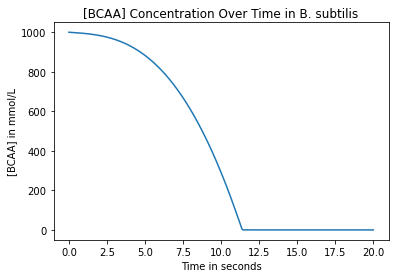

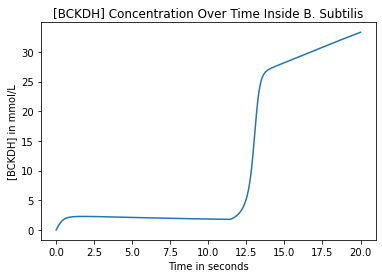

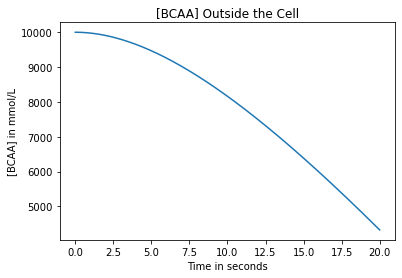

In [6]:
import numpy as np #matrix operations
import matplotlib.pyplot as plt #plotter
from scipy.integrate import odeint #ode solver

species = { #concentrations in mmol/L
    #transport protein
    'bCAP': 0,
    #Enzymes
    'ilvK': 0,
    'BCKDH': 0,
    #Rectants
    'BCAA_out': 10000,
    'BCAA_in': 1000,
    'oxoglutarate': 1,
    'BCKA': 1,
    'NAD+': 1,
    'CoA': 1,
    #Complexes
    'Complex1': 0,
    'Complex2': 0,
}

consts = {
    #ilvK constants
    'lambda_1': 5,
    'sigma_1': 0.1,
    #BCAP constants
    'lambda_2': 5,
    'sigma_2': 0.1,
    #BCKDH constants
    'lambda_3': 5,
    'sigma_3': 0.1, 
    #Rate constants
    'k_1': 100,
    'k_-1': 10,
    'k_2': 10,
    'k_3': 1,
    'k_-3': 0.1,
    'k_4': 10,
    'k_in': 10,
}

#Define reaction.
coa_conc = species['CoA']
nadt_conc = species['NAD+']
oxoglutarate_conc = species['oxoglutarate']

def reaction(conc, time):
    bcaa_conc = conc[0]
    ilvK_conc = conc[1]
    complex1_conc = conc[2]
    bcka_conc = conc[3]
    complex2_conc = conc[4] 
    bckdh_conc = conc[5]
    bcaa_out = conc[6]
    bcap_conc = conc[7]

    dBCAAindt = -consts['k_1']*bcaa_conc*ilvK_conc*oxoglutarate_conc \
        + consts['k_-1']*complex1_conc \
        + consts['k_in']*bcap_conc
    
    dilvKdt = -consts['k_1']*bcaa_conc*ilvK_conc*oxoglutarate_conc \
        + consts['k_-1']*complex1_conc + consts['k_2']*complex1_conc \
        + consts['lambda_1'] - consts['sigma_1']*ilvK_conc
    
    dcomplex1dt = consts['k_1']*bcaa_conc*ilvK_conc \
        - consts['k_-1']*complex1_conc - consts['k_2']*complex1_conc

    dBCKAdt = consts['k_2']*complex1_conc \
        - consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        + consts['k_-3']*complex2_conc
    
    dcomplex2dt = consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        - consts['k_-3']*complex2_conc - consts['k_4']*complex2_conc
    
    dBCKDHdt = -consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        + consts['k_-3']*complex2_conc + consts['k_4']*complex2_conc \
        + consts['lambda_3'] - consts['sigma_3']*bckdh_conc
    
    dBCAAoutdt = -consts['k_in']*bcap_conc
    
    dbCAPdt = consts['lambda_2'] - consts['sigma_2']*bcap_conc

    return [dBCAAindt, dilvKdt, dcomplex1dt, \
        dBCKAdt, dcomplex2dt, dBCKDHdt, \
        dBCAAoutdt, dbCAPdt]

#Define timesteps.
t = np.linspace(0, 20, 1000) #step times

#Solve the ODE with initial condition defined in species.
s = species
initial_conc = [s['BCAA_in'], s['ilvK'], s['Complex1'], \
    s['BCKA'], s['Complex2'], s['BCKDH'], s['BCAA_out'], s['bCAP']]

solution = odeint(reaction, initial_conc, t)

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 0])
plt.title("[BCAA] Concentration Over Time in B. subtilis")
plt.xlabel('Time in seconds')
plt.ylabel('[BCAA] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 5])
plt.title("[BCKDH] Concentration Over Time Inside B. Subtilis")
plt.xlabel('Time in seconds')
plt.ylabel('[BCKDH] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 6])
plt.title("[BCAA] Outside the Cell")
plt.xlabel('Time in seconds')
plt.ylabel('[BCAA] in mmol/L')
plt.show()
    